# Машинное обучение, ВМК МГУ

## Практическое задание 3

### Общая информация
Дата выдачи: 07.12.2017  

Мягкий дедлайн: 23:59MSK 21.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 25.12.2017

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: ml.cmc.msu@gmail.com

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте: 10044865
* Максимальная оценка: 10

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.05070405689974

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.645988957786784

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

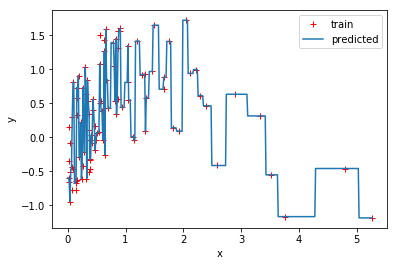

In [50]:
x = np.random.exponential(size=sample_size)
x.sort()
y = f(x) + np.random.uniform(-1, 1, size=sample_size)

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(x[:, np.newaxis], y)
x_test = np.linspace(0, x.max(), 4 * sample_size)
y_pred = model.predict(x_test[:, np.newaxis])

plt.plot(x, y, 'r+', label="train")
plt.plot(x_test, y_pred, label="predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

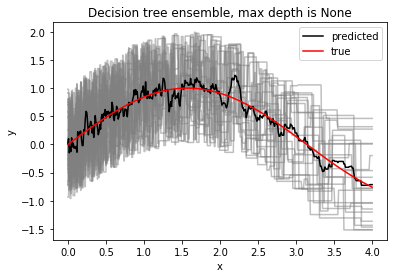

In [52]:
def show_decision_forest(max_depth=None):
    x_test = np.linspace(0, 4, 4 * sample_size)
    y_test = np.zeros(4 * sample_size)

    for i in range(samples_num):
        x_train = np.random.exponential(size=sample_size)
        y_train = f(x_train) + np.random.uniform(-1, 1, size=sample_size)

        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(x_train[:, np.newaxis], y_train)
        y_pred = model.predict(x_test[:, np.newaxis])
        y_test += y_pred

        plt.plot(x_test, y_pred, color="gray", alpha=0.5)

    y_test /= samples_num
    plt.plot(x_test, y_test, color="black", label="predicted")

    plt.plot(x_test, f(x_test), color="red", label="true")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Decision tree ensemble, max depth is {max_depth}".format(max_depth=max_depth))
    plt.show()

show_decision_forest()

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

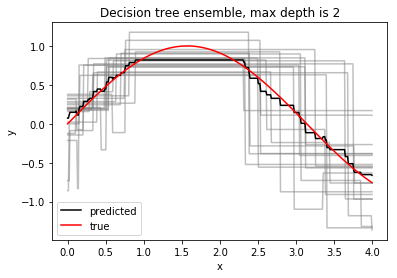

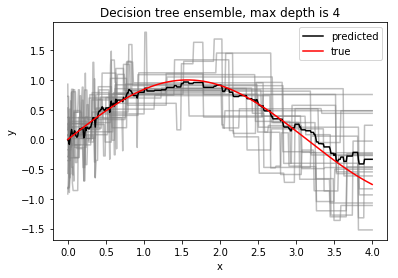

In [53]:
show_decision_forest(2)
show_decision_forest(4)


__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:** В третьем варианте bias меньше всего, так как var большой, а ошибка примерно такая же, как и на других примерах.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [55]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [56]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [4]:
from importlib import reload
import hw3code

reload(hw3code)

<module 'hw3code' from '/home/vs/Documents/NinethSemester/MachineLearning/Homework03/hw3code.py'>

In [76]:
for i, regressor in enumerate(regressors):
    for j, generator in enumerate(generators):
        df_bias.iloc[i, j], df_variance.iloc[i, j] = hw3code.compute_bias_variance(regressor=regressor, 
                                                                                   dependence_fun=lambda x: 5 * np.sin(10 * x),
                                                                                   x_generator=generator,
                                                                                   noise_generator=generator)


__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

In [81]:
df_variance["mean"] = df_variance.values.mean(axis=1)

In [88]:
print("Bias")
display(df_bias)
print("Variance")
display(df_variance.sort_values("mean"))

Bias


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.485,8.15807,11.8634,10.9015
DecisionTree,0.0602464,0.118506,0.00519482,0.00120219
RandomForest,0.0714908,0.131209,0.00408133,0.000960769
GradientBoosting,0.062685,0.121382,0.0156902,0.00144166


Variance


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)",mean
LinearRegression,0.114824,0.0717754,0.0686083,0.058098,0.0783264
GradientBoosting,0.167497,0.189077,0.136171,0.0398846,0.133158
RandomForest,0.154596,0.151285,0.190919,0.0486806,0.13637
DecisionTree,0.225189,0.254711,0.352403,0.0889095,0.230303


**Ответ:**

* Да, согласуется с ожиданиями: 
  * Линейная регрессия не обладает достаточной выразительностью, поэтому у нее низкий разброс, какую бы подвыборку мы не взяли.
  * Буститнг и случайный лес уже выдают усредненный результат, что тоже уменьшает разброс.
  * Деревья склонны к переобучению, поэтому у них самый болльшой разброс.
* Нет, нельзя. Алгоритм учится на шумных данных, поэтому учитывает этот шум при предсказании ответа.
* При нормальном и экспоненциальном распределении $x$. В областях с маленькой плотностью ответ будет очень приближенный.

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
$R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
 $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

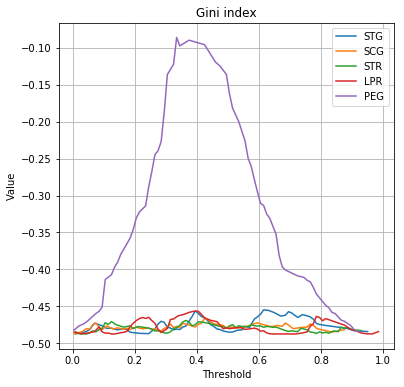

In [96]:
reload(hw3code)

df_stud = pd.read_csv("students.csv")
X = df_stud.drop([" UNS"], axis=1).values
y = df_stud[" UNS"].values

plt.figure(figsize=(6, 6))
for i in range(X.shape[1]):
    thresholds, ginis, _, _ = hw3code.find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=df_stud.columns[i])

plt.title('Gini index')
plt.ylabel('Value')
plt.xlabel('Threshold')
plt.legend()

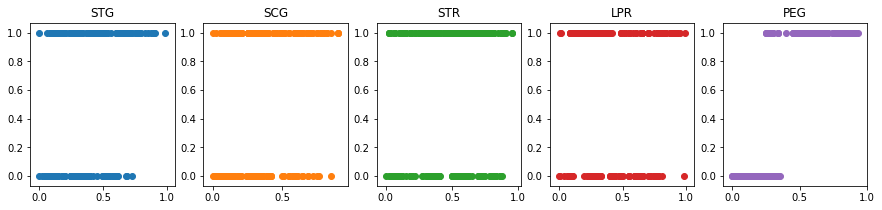

In [94]:
plt.figure(figsize=(15, 3))

for i in range(X.shape[1]):
    plt.subplot(1, 5, i + 1)
    plt.scatter(X[:, i], y, color='C{c}'.format(c=i))
    plt.title(df_stud.columns[i])

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** По признаку PEG. Да, согласуется. У хороших признаков график поднимается до выскокого значения Gini индекса. У плохих признаков значение колеблется возле какого-то значения.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def update_columns(df):
    for column in df.columns:
        df[column] = LabelEncoder().fit_transform(df[column])

df_mushrooms = pd.read_csv('agaricus-lepiota.csv')
update_columns(df_mushrooms)
df_mushrooms = df_mushrooms.values.astype(np.float)
X, y = df_mushrooms[:, 1:], df_mushrooms[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, shuffle=True)

In [7]:
from sklearn.metrics import accuracy_score
reload(hw3code)

model = hw3code.DecisionTree(['categorical'] * X_train.shape[1])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 1.0


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [9]:
df_tic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
update_columns(df_tic)
df_tic = df_tic.values.astype(np.float)
X, y = df_tic[:, :-1], df_tic[:, -1]

In [10]:
from sklearn.model_selection import cross_val_score

def plot_accuracy(name, values, X_train, y_train, title=''):
    acc_values = []
    for value in values:
        model = hw3code.DecisionTree(['categorical'] * X_train.shape[1], **{name: value})
        acc = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
        acc_values.append(np.mean(acc))
        
    plt.plot(values, acc_values)
    plt.title("Accuracy / {}".format(name))
    plt.xlabel(name)
    plt.ylabel('Accuracy')

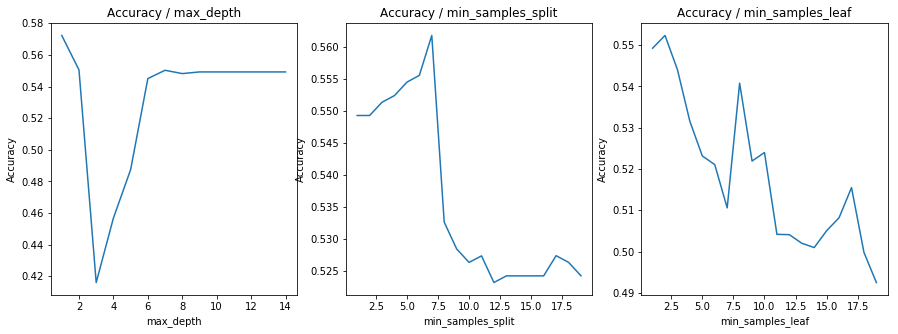

In [11]:
reload(hw3code)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_accuracy('max_depth', range(1, 15), X, y)
plt.subplot(1, 3, 2)
plot_accuracy('min_samples_split', range(1, 20), X, y)
plt.subplot(1, 3, 3)
plot_accuracy('min_samples_leaf', range(1, 20), X, y)

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [13]:
df_cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
df_cars['unacc'] = df_cars['unacc'].apply(lambda x: x in ['good', 'vgood'])
update_columns(df_cars)
df_cars = df_cars.values.astype(np.float)

df_nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')
df_nursery['recommend'] = df_nursery['recommend'].apply(lambda x: x in ['very_recom', 'priority', 'spec_prior'])
update_columns(df_nursery)
df_nursery = df_nursery.values.astype(np.float)

X_nursery, y_nursery = df_nursery[:, :-1], df_nursery[:, -1]
X_cars, y_cars = df_cars[:, :-1], df_cars[:, -1]

In [14]:
data = {
    'mushrooms': (df_mushrooms[:, 1:], df_mushrooms[:, 0]),
    'tic-tae-toe': (df_tic[:, :-1], df_tic[:, -1]),
    'cars': (df_cars[:, :-1], df_cars[:, -1]),
    'nursery': (df_nursery[:, :-1], df_nursery[:, -1])
}

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

df_stat = pd.DataFrame(columns=["Real", "Categoriсal", "Real+one-hot", "Sklearn"], 
                                index=data.keys())

for dataset_name, (X, y) in data.items():
    X_one_hot = np.concatenate((X, OneHotEncoder(sparse=False).fit_transform(X)), axis=1)
    
    models = [hw3code.DecisionTree(['real'] * X.shape[1]), 
              hw3code.DecisionTree(['categorical'] * X.shape[1]), 
              hw3code.DecisionTree(['real'] * X_one_hot.shape[1]), 
              DecisionTreeClassifier()
             ]
    
    for model_name, model, X_train in zip(df_stat.columns, models, [X, X, X_one_hot, X]):
        accuracy = cross_val_score(model, X_train, y, cv=10, scoring='accuracy')
        df_stat.loc[dataset_name, model_name] = np.mean(accuracy)

In [38]:
df_stat

,Real,Categoriсal,Real+one-hot,Sklearn
mushrooms,0.999261,1,0.999631,0.961976
tic-tae-toe,0.462697,0.549265,0.55773,0.726208
cars,0.9426,0.967519,0.924093,0.940374
nursery,0.999846,0.999923,0.999846,0.999846


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Нет, они ранжируются в разном порядке. Точность близкая для всех датасетов, кроме tic-tac-toe, разница во всех остальных датасетах объяснима случайностью.

Кроме того, на наборе данных mushrooms sklearn реализация показывается себя хуже. Эта реализация склонна к недообучению в сравнении с нашей реализацией. Поэтому в mushrooms она показывает себя хуже, но в tic-tac-toe -- лучше, т. к. этот датасет имеет небольшое количество примеров.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [32]:
df_bnp = pd.read_csv("train.csv", index_col="ID").loc[:10000]
y = df_bnp.target.values

df_bnp = df_bnp.drop("target", axis=1)
X = (df_bnp.iloc[:, [dtype == np.float64 for dtype in df_bnp.dtypes]]
     .fillna(0)
     .values
    )

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

models = [
    DecisionTreeClassifier(),
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=100),
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    print(type(model).__name__, accuracy.mean())

DecisionTreeClassifier 0.661057128722
BaggingClassifier 0.742016821059
RandomForestClassifier 0.743728903609


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [34]:
from sklearn.metrics import accuracy_score

x, y = range(20, 5001, 20), []
model = RandomForestClassifier(n_estimators=0, warm_start=True)

for i in x:
    model.set_params(n_estimators=i)
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    y.append(accuracy) 

(0, 1)

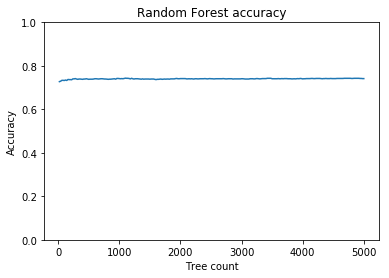

In [35]:
plt.plot(x, y)
plt.title("Random Forest accuracy")
plt.xlabel("Tree count")
plt.ylabel("Accuracy")
plt.ylim([0, 1])

Случайный лес не переобучается.

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

(・・ ) ?